In [82]:
import pandas as pd
from pandas import concat
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras import backend as K



In [174]:
class AutoLSTM():
    
    '''
    Vector Autoregression model

    Attributes
    ----------
    self.data_backup: dataframe, a backup copy of the input dataset
    self.data: dataframe, the main dataset worked on
    self.n: int, length (unit in months) of target to predict
    self.df_result: dataframe, stores the predicted target and the true target
    self.lag: int, number of past months used to predict the target
    self.rmse: rounded RMSE of the prediction
    self.target: str, name of target variable
    self.model: record a CNN trained model
    self.train_result: record model fit result loss
    
    Params
    ----------
    data_name: str, name of the dataset. Notice the input dataset must contain a column named 'Date'
    target_name: str, name of target variable
    drop_cols: list of strings, names of columns to drop
    '''
    def __init__(self, data_name, target_name, drop_cols=['Date']):   
        #import data
        curr_path = os.getcwd()
        input_path = os.path.join(curr_path, data_name)
        data = pd.read_excel(input_path, index_col=0)
        
        #drop columns and na
        data.drop(drop_cols, axis=1, inplace=True)
        data.dropna(inplace = True)
        # data.reset_index(drop=True, inplace=True)
        
        #set attributes
        self.data = data
 
        self.n = 0
        self.df_result = 0
        self.lag = 0
        self.rmse = 0
        self.target = target_name
        self.n_features = len(data.columns) - 1
        self.model = 0
        self.train_result = 0

    
    def print_date_range(self):
        #Print Range of Date column
        print('Date Range: ', self.data_backup['Date'].iloc[0], '--', self.data_backup['Date'].iloc[-1])
    
    # convert series to supervised learning
    def series_to_supervised(self, data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg
    

    def run(self, pred_begin_date, n, lags=3): 
        ''' Run CNN
        
        Params
        ----------
        pred_begin_date: date, the begin date of prediction
        n: int, length of prediction (unit in months)      
        lag: int, num of past months to consider
        if_target: boolean, whether to include target as a predictor
        '''

        # normalize features
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(self.data)
        # flatten data
        reframed = self.series_to_supervised(scaled, lags, 1)
        # drop columns we don't want to predict
        reframed.drop(reframed.columns[range(reframed.shape[1] - self.n_features, reframed.shape[1])], axis=1, inplace=True)
        
        values = reframed.values
        self.n = n

        test_date_begin = self.data.index.get_loc(pred_begin_date) - lags
    
        train = values[:test_date_begin, :]
        test = values[test_date_begin: test_date_begin+self.n, :]


        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        # print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

        # create and fit the LSTM network
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dropout(0.1))
        model.add(Dense(1))
        
        def root_mean_squared_error(y_true, y_pred):
            return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
        model.compile(optimizer='adam', loss=root_mean_squared_error)
        
        result = model.fit(train_X, train_y, verbose=2, validation_data=(test_X, test_y), epochs=50, batch_size=72)
        self.model = model
        self.train_result = result
        
        pred_y = self.model.predict(test_X)

        # reverse standardization
        #test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

        # invert scaling for forecast
        test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        pred_y = pred_y.reshape((len(pred_y), 1))


        inv_yhat = np.concatenate((pred_y, test_X[:, 1:self.n_features+1]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual

        test_y = test_y.reshape((len(test_y), 1))
        inv_y = np.concatenate((test_y, test_X[:, 1:self.n_features+1]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)


        df_result = pd.DataFrame(inv_yhat, columns=[self.target + '_pred'])
        df_result[self.target] = inv_y

        ### TODO modify range

        df_result['Date'] = self.data.index[test_date_begin + lags:  test_date_begin+lags+n]
        df_result.set_index(['Date'],inplace=True)

        self.df_result = df_result
        self.rmse = round(rmse,2)

Epoch 1/50
5/5 - 2s - loss: 0.1314 - val_loss: 0.3363
Epoch 2/50
5/5 - 0s - loss: 0.0734 - val_loss: 0.2290
Epoch 3/50
5/5 - 0s - loss: 0.0678 - val_loss: 0.2995
Epoch 4/50
5/5 - 0s - loss: 0.0682 - val_loss: 0.2338
Epoch 5/50
5/5 - 0s - loss: 0.0612 - val_loss: 0.2434
Epoch 6/50
5/5 - 0s - loss: 0.0522 - val_loss: 0.2616
Epoch 7/50
5/5 - 0s - loss: 0.0465 - val_loss: 0.2584
Epoch 8/50
5/5 - 0s - loss: 0.0450 - val_loss: 0.2636
Epoch 9/50
5/5 - 0s - loss: 0.0427 - val_loss: 0.2548
Epoch 10/50
5/5 - 0s - loss: 0.0406 - val_loss: 0.2652
Epoch 11/50
5/5 - 0s - loss: 0.0400 - val_loss: 0.2512
Epoch 12/50
5/5 - 0s - loss: 0.0397 - val_loss: 0.2539
Epoch 13/50
5/5 - 0s - loss: 0.0377 - val_loss: 0.2422
Epoch 14/50
5/5 - 0s - loss: 0.0348 - val_loss: 0.2370
Epoch 15/50
5/5 - 0s - loss: 0.0331 - val_loss: 0.2296
Epoch 16/50
5/5 - 0s - loss: 0.0314 - val_loss: 0.2226
Epoch 17/50
5/5 - 0s - loss: 0.0305 - val_loss: 0.2202
Epoch 18/50
5/5 - 0s - loss: 0.0297 - val_loss: 0.2145
Epoch 19/50
5/5 - 0

<AxesSubplot:xlabel='Date'>

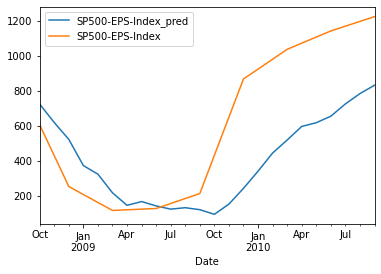

In [179]:
lstm_model = AutoLSTM(data_name='merged_data_1020.xlsx', target_name='SP500-EPS-Index', drop_cols=['SP500-Price','gdp','ManufacturingNewOrders','ConstructionSpending'])
d = '2008-10-01 00:00:00'
n = 24
l = 15
lstm_model.run(pred_begin_date=d, n=n, lags=l)
lstm_model.df_result.plot()

In [167]:
lstm_model.data.columns

Index(['SP500-EPS-Index', 'IndustrialProduction', 'GS10', 'CPIFABSL',
       'MedianUsualWeeklyRealEarnings', 'PCE', 'PPI',
       'VolumeOfTotalRetailTradeSales-GR', 'HousingSales', 'UnemploymentRate',
       'EffectiveRate', 'M2', 'GovernmentBudgetBalance'],
      dtype='object')